In [1]:
from dotenv import load_dotenv, find_dotenv

load_dotenv(find_dotenv())

True

In [2]:
# import for asynchronous tasks
import asyncio
import nest_asyncio

nest_asyncio.apply()

In [3]:
# === LLM Compiler: Tool Setup ===
from langchain_community.tools.tavily_search import TavilySearchResults

search = TavilySearchResults(
    max_results=1,
    description='tavily_search_results_json(query="the search query") - a search engine.',
)

tools = [search]

In [4]:
from pydantic import BaseModel
from langchain_community.tools.tavily_search import TavilySearchResults


# Define a custom encoder for TavilySearchResults
def tavily_encoder(tool: TavilySearchResults):
    return {
        "name": tool.name,
        "max_results": tool.max_results,
        "description": tool.description,
    }


# Create a Pydantic wrapper model for the tool
class ToolWrapper(BaseModel):
    tool: TavilySearchResults

    class Config:
        json_encoders = {
            TavilySearchResults: tavily_encoder,
        }


In [5]:
search.name

'tavily_search_results_json'

In [6]:
import ast
import re
from typing import (
    Any,
    Dict,
    Iterator,
    List,
    Optional,
    Sequence,
    Tuple,
    Union,
)

from langchain_core.exceptions import OutputParserException
from langchain_core.messages import BaseMessage
from langchain_core.output_parsers.transform import BaseTransformOutputParser
from langchain_core.runnables import RunnableConfig
from langchain_core.tools import BaseTool
from typing_extensions import TypedDict

THOUGHT_PATTERN = r"Thought: ([^\n]*)"
ACTION_PATTERN = r"\n*(\d+)\. (\w+)\((.*)\)(\s*#\w+\n)?"
# $1 or ${1} -> 1
ID_PATTERN = r"\$\{?(\d+)\}?"
END_OF_PLAN = "<END_OF_PLAN>"


### Helper functions


def _ast_parse(arg: str) -> Any:
    try:
        return ast.literal_eval(arg)
    except:  # noqa
        return arg


def _parse_llm_compiler_action_args(args: str, tool: Union[str, BaseTool]) -> list[Any]:
    """Parse arguments from a string."""
    if args == "":
        return ()
    if isinstance(tool, str):
        return ()
    extracted_args = {}
    tool_key = None
    prev_idx = None
    for key in tool.args.keys():
        # Split if present
        if f"{key}=" in args:
            idx = args.index(f"{key}=")
            if prev_idx is not None:
                extracted_args[tool_key] = _ast_parse(
                    args[prev_idx:idx].strip().rstrip(",")
                )
            args = args.split(f"{key}=", 1)[1]
            tool_key = key
            prev_idx = 0
    if prev_idx is not None:
        extracted_args[tool_key] = _ast_parse(
            args[prev_idx:].strip().rstrip(",").rstrip(")")
        )
    return extracted_args


def default_dependency_rule(idx, args: str):
    matches = re.findall(ID_PATTERN, args)
    numbers = [int(match) for match in matches]
    return idx in numbers


def _get_dependencies_from_graph(
    idx: int, tool_name: str, args: Dict[str, Any]
) -> dict[str, list[str]]:
    """Get dependencies from a graph."""
    if tool_name == "join":
        return list(range(1, idx))
    return [i for i in range(1, idx) if default_dependency_rule(i, str(args))]


class Task(TypedDict):
    idx: int
    tool: BaseTool
    args: list
    dependencies: Dict[str, list]
    thought: Optional[str]


def instantiate_task(
    tools: Sequence[BaseTool],
    idx: int,
    tool_name: str,
    args: Union[str, Any],
    thought: Optional[str] = None,
) -> Task:
    if tool_name == "join":
        tool = "join"
    else:
        try:
            tool = tools[[tool.name for tool in tools].index(tool_name)]
        except ValueError as e:
            raise OutputParserException(f"Tool {tool_name} not found.") from e
    tool_args = _parse_llm_compiler_action_args(args, tool)
    dependencies = _get_dependencies_from_graph(idx, tool_name, tool_args)

    return Task(
        idx=idx,
        tool=tool,
        args=tool_args,
        dependencies=dependencies,
        thought=thought,
    )


class LLMCompilerPlanParser(BaseTransformOutputParser[dict], extra="allow"):
    """Planning output parser."""

    tools: List[BaseTool]

    def _transform(self, input: Iterator[Union[str, BaseMessage]]) -> Iterator[Task]:
        texts = []
        # TODO: Cleanup tuple state tracking here.
        thought = None
        for chunk in input:
            # Assume input is str. TODO: support vision/other formats
            text = chunk if isinstance(chunk, str) else str(chunk.content)
            for task, thought in self.ingest_token(text, texts, thought):
                yield task
        # Final possible task
        if texts:
            task, _ = self._parse_task("".join(texts), thought)
            if task:
                yield task

    def parse(self, text: str) -> List[Task]:
        return list(self._transform([text]))

    def stream(
        self,
        input: str | BaseMessage,
        config: RunnableConfig | None = None,
        **kwargs: Any | None,
    ) -> Iterator[Task]:
        yield from self.transform([input], config, **kwargs)

    def ingest_token(
        self, token: str, buffer: List[str], thought: Optional[str]
    ) -> Iterator[Tuple[Optional[Task], str]]:
        buffer.append(token)
        if "\n" in token:
            buffer_ = "".join(buffer).split("\n")
            suffix = buffer_[-1]
            for line in buffer_[:-1]:
                task, thought = self._parse_task(line, thought)
                if task:
                    yield task, thought
            buffer.clear()
            buffer.append(suffix)

    def _parse_task(self, line: str, thought: Optional[str] = None):
        task = None
        if match := re.match(THOUGHT_PATTERN, line):
            # Optionally, action can be preceded by a thought
            thought = match.group(1)
        elif match := re.match(ACTION_PATTERN, line):
            # if action is parsed, return the task, and clear the buffer
            idx, tool_name, args, _ = match.groups()
            idx = int(idx)
            task = instantiate_task(
                tools=self.tools,
                idx=idx,
                tool_name=tool_name,
                args=args,
                thought=thought,
            )
            thought = None
        # Else it is just dropped
        return task, thought

In [7]:
from typing import Sequence

from langchain import hub
from langchain_core.language_models import BaseChatModel
from langchain_core.messages import (
    BaseMessage,
    FunctionMessage,
    HumanMessage,
    SystemMessage,
)
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableBranch
from langchain_core.tools import BaseTool
from langchain_openai import ChatOpenAI
from typing import Annotated, Union
from langchain_core.messages import AIMessage, SystemMessage, ChatMessage, FunctionMessage, ToolMessage, AIMessageChunk, HumanMessageChunk, ChatMessageChunk, SystemMessageChunk, FunctionMessageChunk, ToolMessageChunk
from langchain.prompts import ChatPromptTemplate

prompt = hub.pull("wfh/llm-compiler")
# prompt = ChatPromptTemplate.from_template("""
# Given a user query, create a plan to solve it with the utmost parallelizability. Each plan should comprise an action from the following {num_tools} types:
# {tool_descriptions}
# {num_tools}. join(): Collects and combines results from prior actions.

# - An LLM agent is called upon invoking join() to either finalize the user query or wait until the plans are executed.
# - join should always be the last action in the plan, and will be called in two scenarios:
#   (a) if the answer can be determined by gathering the outputs from tasks to generate the final response.
#   (b) if the answer cannot be determined in the planning phase before you execute the plans.

# Guidelines:
# - Each action described above contains input/output types and description.
# - You must strictly adhere to the input and output types for each action.
# - The action descriptions contain the guidelines. You MUST strictly follow those guidelines when you use the actions.
# - Each action in the plan should strictly be one of the above types. Follow the Python conventions for each action.
# - Each action MUST have a unique ID, which is strictly increasing.
# - Inputs for actions can either be constants or outputs from preceding actions. In the latter case, use the format $id to denote the ID of the previous action whose output will be the input.
# - Always call join as the last action in the plan. Say '<END_OF_PLAN>' after you call join.
# - Ensure the plan maximizes parallelizability.
# - Only use the provided action types. If a query cannot be addressed using these, invoke the join action for the next steps.
# - Never introduce new actions other than the ones provided.

# {messages}

# Remember, ONLY respond with the task list in the correct format! E.g.:
# 1. tool_name(arg_name=args)
# 2. another_tool(arg_name=args)
# 3. join(input=$1, $2)
# <END_OF_PLAN>
# """)

In [8]:
def create_planner(
    llm: BaseChatModel, tools: Sequence[BaseTool], base_prompt: ChatPromptTemplate
):
    tool_descriptions = "\n".join(
        f"{i+1}. {tool.description}\n"
        for i, tool in enumerate(
            tools
        )  # +1 to offset the 0 starting index, we want it count normally from 1.
    )
    planner_prompt = base_prompt.partial(
        replan="",
        num_tools=len(tools)
        + 1,  # Add one because we're adding the join() tool at the end.
        tool_descriptions=tool_descriptions,
    )
    replanner_prompt = base_prompt.partial(
        replan=' - You are given "Previous Plan" which is the plan that the previous agent created along with the execution results '
        "(given as Observation) of each plan and a general thought (given as Thought) about the executed results."
        'You MUST use these information to create the next plan under "Current Plan".\n'
        ' - When starting the Current Plan, you should start with "Thought" that outlines the strategy for the next plan.\n'
        " - In the Current Plan, you should NEVER repeat the actions that are already executed in the Previous Plan.\n"
        " - You must continue the task index from the end of the previous one. Do not repeat task indices.",
        num_tools=len(tools) + 1,
        tool_descriptions=tool_descriptions,
    )

    def should_replan(state: list):
        # Context is passed as a system message
        return isinstance(state[-1], SystemMessage)

    def wrap_messages(state: list):
        return {"messages": state}

    def wrap_and_get_last_index(state: list):
        next_task = 0
        for message in state[::-1]:
            if isinstance(message, FunctionMessage):
                next_task = message.additional_kwargs["idx"] + 1
                break
        state[-1].content = state[-1].content + f" - Begin counting at : {next_task}"
        return {"messages": state}

    return (
        RunnableBranch(
            (should_replan, wrap_and_get_last_index | replanner_prompt),
            wrap_messages | planner_prompt,
        )
        | llm
        | LLMCompilerPlanParser(tools=tools)
    )

In [9]:
llm = ChatOpenAI(model="gpt-4o")
# This is the primary "agent" in our application
planner = create_planner(llm, tools, prompt)

In [10]:
from pprint import pprint

example_question = "What's the difference in temperature between SF and NY?"

for task in planner.stream([HumanMessage(content=example_question)]):
    print(task["tool"])
    print(task["args"])
    # pprint(task["tool"])
    print("---")

description='tavily_search_results_json(query="the search query") - a search engine.' max_results=1 api_wrapper=TavilySearchAPIWrapper(tavily_api_key=SecretStr('**********'))
{'query': 'current temperature in San Francisco'}
---
description='tavily_search_results_json(query="the search query") - a search engine.' max_results=1 api_wrapper=TavilySearchAPIWrapper(tavily_api_key=SecretStr('**********'))
{'query': 'current temperature in New York'}
---
join
()
---


In [22]:
import re
import time
from concurrent.futures import ThreadPoolExecutor, wait
from typing import Any, Dict, Iterable, List, Union

from langchain_core.runnables import (
    chain as as_runnable,
)
from typing_extensions import TypedDict


def _get_observations(messages: List[BaseMessage]) -> Dict[int, Any]:
    # Get all previous tool responses
    results = {}
    for message in messages[::-1]:
        if isinstance(message, FunctionMessage):
            results[int(message.additional_kwargs["idx"])] = message.content
    return results


class SchedulerInput(TypedDict):
    messages: List[BaseMessage]
    tasks: Iterable[Task]


def _execute_task(task, observations, config):
    tool_to_use = task["tool"]
    if isinstance(tool_to_use, str):
        return tool_to_use
    args = task["args"]
    try:
        if isinstance(args, str):
            resolved_args = _resolve_arg(args, observations)
        elif isinstance(args, dict):
            resolved_args = {
                key: _resolve_arg(val, observations) for key, val in args.items()
            }
        else:
            # This will likely fail
            resolved_args = args
    except Exception as e:
        return (
            f"ERROR(Failed to call {tool_to_use.name} with args {args}.)"
            f" Args could not be resolved. Error: {repr(e)}"
        )
    try:
        return tool_to_use.invoke(resolved_args, config)
    except Exception as e:
        return (
            f"ERROR(Failed to call {tool_to_use.name} with args {args}."
            + f" Args resolved to {resolved_args}. Error: {repr(e)})"
        )


def _resolve_arg(arg: Union[str, Any], observations: Dict[int, Any]):
    # $1 or ${1} -> 1
    ID_PATTERN = r"\$\{?(\d+)\}?"

    def replace_match(match):
        # If the string is ${123}, match.group(0) is ${123}, and match.group(1) is 123.

        # Return the match group, in this case the index, from the string. This is the index
        # number we get back.
        idx = int(match.group(1))
        return str(observations.get(idx, match.group(0)))

    # For dependencies on other tasks
    if isinstance(arg, str):
        return re.sub(ID_PATTERN, replace_match, arg)
    elif isinstance(arg, list):
        return [_resolve_arg(a, observations) for a in arg]
    else:
        return str(arg)


@as_runnable
def schedule_task(task_inputs, config):
    task: Task = task_inputs["task"]
    observations: Dict[int, Any] = task_inputs["observations"]
    try:
        observation = _execute_task(task, observations, config)
    except Exception:
        import traceback
        observation = traceback.format_exception()  # repr(e) +
    observations[task["idx"]] = observation


def schedule_pending_task(
    task: Task, observations: Dict[int, Any], retry_after: float = 0.2
):
    while True:
        deps = task["dependencies"]
        if deps and (any([dep not in observations for dep in deps])):
            # Dependencies not yet satisfied
            time.sleep(retry_after)
            continue
        schedule_task.invoke({"task": task, "observations": observations})
        break


@as_runnable
def schedule_tasks(scheduler_input: SchedulerInput) -> List[FunctionMessage]:
    """Group the tasks into a DAG schedule."""
    # For streaming, we are making a few simplifying assumption:
    # 1. The LLM does not create cyclic dependencies
    # 2. That the LLM will not generate tasks with future deps
    # If this ceases to be a good assumption, you can either
    # adjust to do a proper topological sort (not-stream)
    # or use a more complicated data structure
    tasks = scheduler_input["tasks"]
    args_for_tasks = {}
    messages = scheduler_input["messages"]
    # If we are re-planning, we may have calls that depend on previous
    # plans. Start with those.
    observations = _get_observations(messages)
    task_names = {}
    originals = set(observations)
    # ^^ We assume each task inserts a different key above to
    # avoid race conditions...
    futures = []
    retry_after = 0.25  # Retry every quarter second
    with ThreadPoolExecutor() as executor:
        for task in tasks:
            deps = task["dependencies"]
            task_names[task["idx"]] = (
                task["tool"] if isinstance(task["tool"], str) else task["tool"].name
            )
            args_for_tasks[task["idx"]] = task["args"]
            if (
                # Depends on other tasks
                deps
                and (any([dep not in observations for dep in deps]))
            ):
                futures.append(
                    executor.submit(
                        schedule_pending_task, task, observations, retry_after
                    )
                )
            else:
                # No deps or all deps satisfied
                # can schedule now
                schedule_task.invoke(dict(task=task, observations=observations))
                # futures.append(executor.submit(schedule_task.invoke, dict(task=task, observations=observations)))

        # All tasks have been submitted or enqueued
        # Wait for them to complete
        wait(futures)
    # Convert observations to new tool messages to add to the state
    new_observations = {
        k: (task_names[k], args_for_tasks[k], observations[k])
        for k in sorted(observations.keys() - originals)
    }
    tool_messages = [
        FunctionMessage(
            name=name,
            content=str(obs),
            additional_kwargs={"idx": k, "args": task_args},
            tool_call_id=k,
        )
        for k, (name, task_args, obs) in new_observations.items()
    ]
    return tool_messages

In [23]:
import itertools


@as_runnable
def plan_and_schedule(state):
    messages = state["messages"]
    tasks = planner.stream(messages)
    # Begin executing the planner immediately
    try:
        tasks = itertools.chain([next(tasks)], tasks)
    except StopIteration:
        # Handle the case where tasks is empty.
        tasks = iter([])
    scheduled_tasks = schedule_tasks.invoke(
        {
            "messages": messages,
            "tasks": tasks,
        }
    )
    return {"messages": scheduled_tasks}

## Joiner

In [24]:
from langchain_core.messages import AIMessage

from pydantic import BaseModel, Field


class FinalResponse(BaseModel):
    """The final response/answer."""

    response: str


class Replan(BaseModel):
    feedback: str = Field(
        description="Analysis of the previous attempts and recommendations on what needs to be fixed."
    )


class JoinOutputs(BaseModel):
    """Decide whether to replan or whether you can return the final response."""

    thought: str = Field(
        description="The chain of thought reasoning for the selected action"
    )
    action: Union[FinalResponse, Replan]


joiner_prompt = hub.pull("wfh/llm-compiler-joiner").partial(
    examples=""
)  # You can optionally add examples
llm = ChatOpenAI(model="gpt-4o")

runnable = joiner_prompt | llm.with_structured_output(
    JoinOutputs, method="function_calling"
)

In [25]:
def _parse_joiner_output(decision: JoinOutputs) -> List[BaseMessage]:
    response = [AIMessage(content=f"Thought: {decision.thought}")]
    if isinstance(decision.action, Replan):
        return {
            "messages": response
            + [
                SystemMessage(
                    content=f"Context from last attempt: {decision.action.feedback}"
                )
            ]
        }
    else:
        return {"messages": response + [AIMessage(content=decision.action.response)]}


def select_recent_messages(state) -> dict:
    messages = state["messages"]
    selected = []
    for msg in messages[::-1]:
        selected.append(msg)
        if isinstance(msg, HumanMessage):
            break
    return {"messages": selected[::-1]}


joiner = select_recent_messages | runnable | _parse_joiner_output

## LangGraph

In [26]:
from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import add_messages
from typing import Annotated


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

# 1.  Define vertices
# We defined plan_and_schedule above already
# Assign each node to a state variable to update
graph_builder.add_node("plan_and_schedule", plan_and_schedule)
graph_builder.add_node("join", joiner)


## Define edges
graph_builder.add_edge("plan_and_schedule", "join")

### This condition determines looping logic


def should_continue(state):
    messages = state["messages"]
    if isinstance(messages[-1], AIMessage):
        return END
    return "plan_and_schedule"


graph_builder.add_conditional_edges(
    "join",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
)
graph_builder.add_edge(START, "plan_and_schedule")
graph = graph_builder.compile()

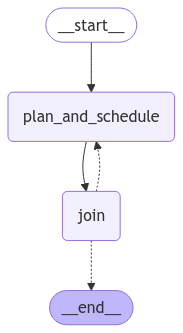

In [27]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

# Visualize the compiled StateGraph as a Mermaid diagram
display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [28]:
import warnings
warnings.filterwarnings("ignore")

In [29]:
# steps = graph.stream(
#     {
#         "messages": [
#             HumanMessage(
#                 content="What are the key differences in economic policies between the current governments of the United States, China, and Germany, and how have these policies impacted their respective GDP growth rates over the past three years?"
#             )
#         ]
#     },
#     {
#         "recursion_limit": 100,
#     },
#     stream_mode="messages",
# )
# for step in steps:
#     print()
#     pprint(step)
#     print("---")

In [30]:
import asyncio
from typing import Any, Dict, List, Callable
from langchain_core.runnables import RunnableConfig
from langgraph.graph.state import CompiledStateGraph


async def astream_graph(
    graph: CompiledStateGraph,
    inputs: Dict[str, Any],
    config: RunnableConfig,
    node_names: List[str] = [],
    callback: Callable[[Dict[str, str]], None] = None,
):
    """
    LangGraph의 실행 결과를 비동기 방식으로 스트리밍하여 출력하는 함수입니다.

    매개변수:
    - graph (CompiledStateGraph): 실행할 컴파일된 LangGraph 객체
    - inputs (dict): 그래프에 전달할 입력값 딕셔너리
    - config (RunnableConfig): 실행 설정
    - node_names (List[str], optional): 출력할 노드 이름 목록 (빈 리스트면 모든 노드 출력)
    - callback (Callable[[Dict[str, str]], None], optional): 각 청크 처리를 위한 콜백 함수 (기본값: None)
      콜백 함수는 {"node": str, "content": str} 형태의 딕셔너리를 인자로 받습니다.

    반환값:
    - None: 함수는 스트리밍 결과를 출력만 하고 반환값은 없습니다.
    """
    prev_node = ""
    async for chunk_msg, metadata in graph.astream(
        inputs, config, stream_mode="messages"
    ):
        curr_node = metadata["langgraph_node"]

        # node_names가 비어있거나 현재 노드가 node_names에 포함된 경우에만 처리
        if not node_names or curr_node in node_names:
            if callback:
                callback({"node": curr_node, "content": chunk_msg.content})
            else:
                # 노드가 변경될 때마다 헤더를 출력
                if curr_node != prev_node:
                    print("\n" + "=" * 60)
                    print(f"🔹 Node: \033[1;34m{curr_node}\033[0m 🔹")
                    print("=" * 60)

                # 콘텐츠를 보기 좋게 출력
                print(chunk_msg.content, end="", flush=True)
                # if content.startswith("{") or content.startswith("["):
                #     try:
                #         import json

                #         parsed = json.loads(content)
                #         formatted = json.dumps(parsed, indent=4, ensure_ascii=False)
                #         print(formatted)
                #     except (json.JSONDecodeError, TypeError):
                #         print(content)
                # else:
                #     print(content)

            prev_node = curr_node

In [31]:
config = {
    "configurable": {
        "thread_id": 1,  # temporary thread ID for testing
    },
}

inputs = State(
    model="openai",
    messages=[
        HumanMessage(
            content="What are the key differences in economic policies between the current governments of the United States, China, and Germany, and how have these policies impacted their respective GDP growth rates over the past three years?"
        )
    ],
    steps=[],
    answer=None,
)

In [ ]:
await astream_graph(graph, inputs, config=config)


🔹 Node: plan_and_schedule 🔹
1. tavily_search_results_json(query="current economic policies of the United States 202

Failed to use model_dump to serialize <class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'> to JSON: PydanticSerializationError(Unable to serialize unknown type: <class 'pydantic._internal._model_construction.ModelMetaclass'>)


3")


Failed to use model_dump to serialize <class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'> to JSON: PydanticSerializationError(Unable to serialize unknown type: <class 'pydantic._internal._model_construction.ModelMetaclass'>)


2.

Failed to use model_dump to serialize <class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'> to JSON: PydanticSerializationError(Unable to serialize unknown type: <class 'pydantic._internal._model_construction.ModelMetaclass'>)


 tavily_search_results_json(query="current economic policies of China 2023")


Failed to use model_dump to serialize <class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'> to JSON: PydanticSerializationError(Unable to serialize unknown type: <class 'pydantic._internal._model_construction.ModelMetaclass'>)


3.

Failed to use model_dump to serialize <class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'> to JSON: PydanticSerializationError(Unable to serialize unknown type: <class 'pydantic._internal._model_construction.ModelMetaclass'>)


 tavily_search_results_json(query="current economic policies of Germany 2023")


Failed to use model_dump to serialize <class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'> to JSON: PydanticSerializationError(Unable to serialize unknown type: <class 'pydantic._internal._model_construction.ModelMetaclass'>)
Failed to use model_dump to serialize <class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'> to JSON: PydanticSerializationError(Unable to serialize unknown type: <class 'pydantic._internal._model_construction.ModelMetaclass'>)


CancelledError: 

Failed to use model_dump to serialize <class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'> to JSON: PydanticSerializationError(Unable to serialize unknown type: <class 'pydantic._internal._model_construction.ModelMetaclass'>)
Failed to use model_dump to serialize <class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'> to JSON: PydanticSerializationError(Unable to serialize unknown type: <class 'pydantic._internal._model_construction.ModelMetaclass'>)
Failed to use model_dump to serialize <class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'> to JSON: PydanticSerializationError(Unable to serialize unknown type: <class 'pydantic._internal._model_construction.ModelMetaclass'>)
Failed to use model_dump to serialize <class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'> to JSON: PydanticSerializationError(Unable to serialize unknown type: <class 'pydantic._internal._model_construction.ModelMetaclass'>)
Failed t